# Imputing Missing Data
Using the three methods we landed on:
- Mutliple Iterations with Chained Equations
- missForest
- Autoregressive Integrated Moving Average

In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import sys
sys.path.append('../')

from src.visualization import visualize
from src.processing import impute

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math
import statsmodels.api as sm

from datetime import datetime, timedelta

# Data Import
For each imputation method, we have two datasets we consider:
1. Example data to test the accuracy of the model
2. Remaining participant data that we can apply the model to. 

In [3]:
imp = impute.Impute("rnse61g4","../",prompt=True,consecutive=True,start_time=datetime(2020,6,15),end_time=datetime(2020,7,15))

Percent: 10
Parameter: co2
Period (in minutes): 60


## Missing Data

In [4]:
imp.missing.head()

pm2p5_mass        tvoc  temperature_c         co  \
timestamp                                                               
2020-06-15 00:00:00   16.385377  482.026194      23.190429  15.838120   
2020-06-15 00:02:00   16.303059  474.969316      23.158287  15.969041   
2020-06-15 00:04:00   15.922074  468.159654      23.126145  16.082330   
2020-06-15 00:06:00   16.105924  461.814457      23.094003  16.202588   
2020-06-15 00:08:00   16.460769  455.708984      23.061861  16.315779   

                            co2  
timestamp                        
2020-06-15 00:00:00  901.932129  
2020-06-15 00:02:00  901.096654  
2020-06-15 00:04:00  900.080625  
2020-06-15 00:06:00  899.522697  
2020-06-15 00:08:00  899.081728

## Base Data
Same dataset with nothing missing - to compare against.

In [5]:
imp.base.head()

tvoc         co2         co  pm2p5_mass  pm10_mass  \
timestamp                                                                       
2020-06-15 00:00:00  482.026194  901.932129  15.838120   16.385377   2.398899   
2020-06-15 00:02:00  474.969316  901.096654  15.969041   16.303059   2.388538   
2020-06-15 00:04:00  468.159654  900.080625  16.082330   15.922074   2.351452   
2020-06-15 00:06:00  461.814457  899.522697  16.202588   16.105924   2.365971   
2020-06-15 00:08:00  455.708984  899.081728  16.315779   16.460769   2.403413   

                     temperature_c  
timestamp                           
2020-06-15 00:00:00      23.190429  
2020-06-15 00:02:00      23.158287  
2020-06-15 00:04:00      23.126145  
2020-06-15 00:06:00      23.094003  
2020-06-15 00:08:00      23.061861

### Getting Comparison Threshold
Some of the sensors don't have a set accuracy but a percent of the measured value so we determine what tha approximate threshold is.

In [6]:
def summarize_param(df,param,plot=False):
    """
    Summarizes the measurements from the complete dataset over the given period
    """
    print(f"{param.upper()}:\n\tMin: {np.min(df[param])}\n\tMean: {np.mean(df[param])}\n\tMedian: {np.median(df[param])}\n\tMax: {np.max(df[param])}")
    
    if plot:
        _, ax = plt.subplots(figsize=(24,4))
        ax.plot(df.index,df[param],lw=2,color="black")
        # y-axis
        ax.set_ylim([np.min(df[param]),np.max(df[param])])
        ax.axhline(np.mean(df[param]),lw=2,ls="dashed",color="firebrick")
    

CO:
	Min: 11.309768692999205
	Mean: 15.139693696238297
	Median: 15.561089136052788
	Max: 21.12372724188965


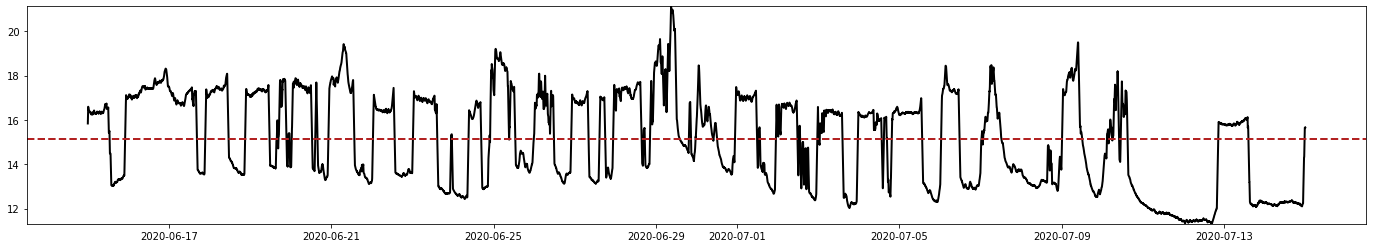

In [7]:
summarize_param(imp.base,"co",plot=True)

TVOC:
	Min: 213.5839131
	Mean: 469.4759898709102
	Median: 461.6396582993677
	Max: 915.54098134796


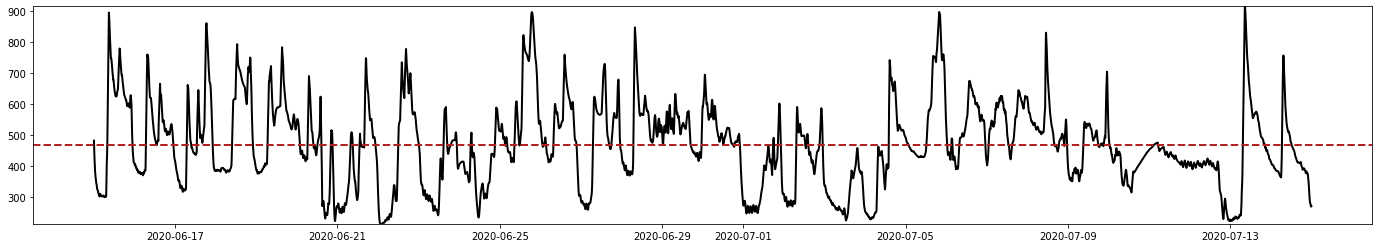

In [8]:
summarize_param(imp.base,"tvoc",plot=True)

In [9]:
0.15*450

67.5

---

# Imputing

## MICE

In [31]:
imp.mice()

In [32]:
imp.mice_imputed.head()

pm2p5_mass        tvoc  temperature_c         co  \
2020-06-15 00:00:00   16.385377  482.026194      23.190429  15.838120   
2020-06-15 00:02:00   16.303059  474.969316      23.158287  15.969041   
2020-06-15 00:04:00   15.922074  468.159654      23.126145  16.082330   
2020-06-15 00:06:00   16.105924  461.814457      23.094003  16.202588   
2020-06-15 00:08:00   16.460769  455.708984      23.061861  16.315779   

                            co2  
2020-06-15 00:00:00  901.932129  
2020-06-15 00:02:00  901.096654  
2020-06-15 00:04:00  900.080625  
2020-06-15 00:06:00  899.522697  
2020-06-15 00:08:00  899.081728

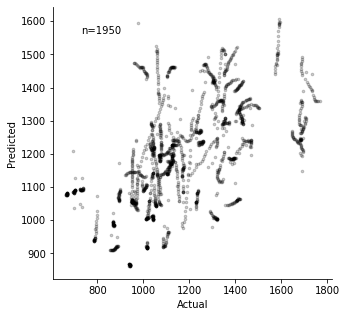

(0.3047112623461705,
 152.94694936117696,
 196.88062393752264,
 0.7142257412078374)

In [33]:
imp.evaluate(imp.mice_imputed,plot=True)

## missForest

### Optimizing Parameters
Need to understand what is the optimal depth and number of estimators.

<div class="alert-block alert alert-info">
    
The real bottleneck seems to be the number of estimators. Some notes:
    
* $\uparrow$ ```max_depth``` by factor $n$, $\uparrow$ $t$ by $n$
* $\uparrow$ ```n_estimators``` by factor $n$, $\uparrow$ $t$ by 
    
Increasing the ```max_depth``` is more beneficial than increasing the ```n_estimators```.
    
</div>

In [145]:
res_rf = imp.optimize_rf(percents=[10],n_estimators=[50,100],max_depths=[20,50],start_time=datetime(2020,6,15),end_time=datetime(2020,6,22),verbose=True)

Percent: 10 - Estimators: 50 - Depth: 20
	Iteration 0
	Iteration 1
	Iteration 2
	Time to execute: 264.57699 seconds
Percent: 10 - Estimators: 50 - Depth: 50
	Iteration 0
	Iteration 1
	Iteration 2
	Time to execute: 265.703083 seconds
Percent: 10 - Estimators: 100 - Depth: 20
	Iteration 0
	Iteration 1
	Iteration 2
	Time to execute: 546.137683 seconds
Percent: 10 - Estimators: 100 - Depth: 50
	Iteration 0
	Iteration 1
	Iteration 2
	Time to execute: 550.765686 seconds


In [146]:
res_rf.sort_values(["Percent","Pearson Correlation","MAE"],ascending=False)

Percent  Estimators  Depth  Time to Execute  Pearson Correlation  \
3       10         100     50       550.765686             0.969737   
2       10         100     20       546.137683             0.967057   
1       10          50     50       265.703083             0.966722   
0       10          50     20       264.576990             0.962185   

         MAE       RMSE  Index of Agreement  
3   9.875074  26.898297            0.992222  
2  10.269774  27.974375            0.991480  
1   9.589840  27.538647            0.991465  
0  10.883727  30.307294            0.990277

### Testing

In [11]:
imp.miss_forest()

In [12]:
imp.rf_imputed.head()

pm2p5_mass        tvoc  temperature_c         co  \
timestamp                                                               
2020-06-11 13:52:00   22.713558  340.623409      24.037599  21.819001   
2020-06-11 13:54:00   22.796582  343.521858      24.077255  21.523549   
2020-06-11 13:56:00   22.721861  346.349039      24.113462  21.237295   
2020-06-11 13:58:00   22.634113  349.113860      24.146652  20.965720   
2020-06-11 14:00:00   22.695872  351.621536      24.177187  20.715069   

                             co2  
timestamp                         
2020-06-11 13:52:00  1412.201879  
2020-06-11 13:54:00  1411.594738  
2020-06-11 13:56:00  1410.994147  
2020-06-11 13:58:00  1410.628738  
2020-06-11 14:00:00  1409.933588

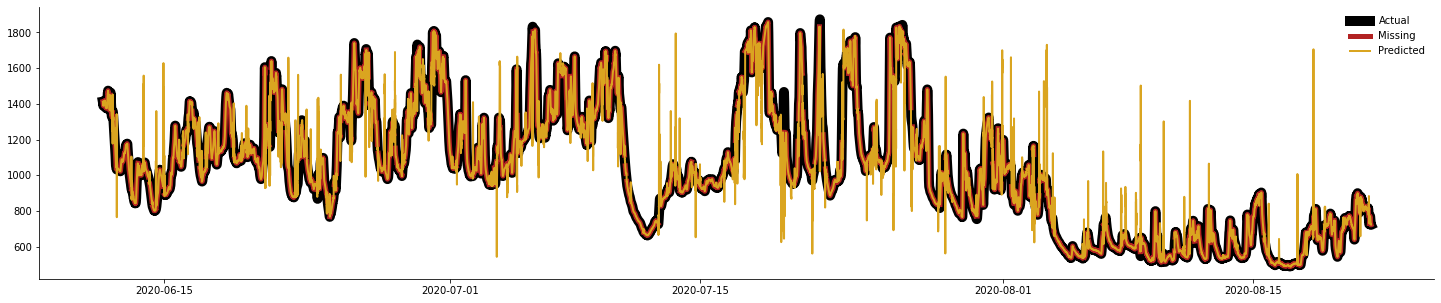

In [13]:
imp.compare_ts(imp.rf_imputed)

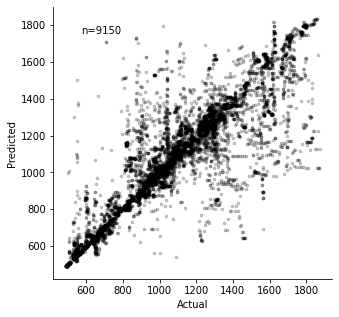

(0.7603589715260368, 86.56529844657902, 160.89429361327694, 0.9329343096015391)

In [14]:
imp.evaluate(imp.rf_imputed,plot=True)

## ARIMA

### Optimizing Order
Need to figure out what the optimal order for the ARIMA is

In [39]:
for param in ["co2","pm2p5_mass","co","tvoc","temperature_c"]:
    res_arima = imp.optimize_arima(start_time=datetime(2020,6,15),end_time=datetime(2020,6,22),verbose=True)
    res_arima.sort_values(["Period","MAE"],ascending=True).to_csv(f"/Users/hagenfritz/Desktop/{param}_arima.csv")

P:2 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 3.798506 seconds
P:2 - D:0 - Q:2
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.820921 seconds
P:2 - D:0 - Q:3
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 7.713397 seconds
P:3 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.101817 seconds
P:3 - D:0 - Q:2
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.894788 seconds
P:3 - D:0 - Q:3
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 5.717354 seconds
P:2 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 3.434739 seconds
P:2 - D:0 - Q:2
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.169762 seconds
P:2 - D:0 - Q:3
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 5.775099 seconds
P:3 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.305288 seconds
P:3 - D:0 

	Iteration 1...
	Iteration 2...
	Time to execute: 5.888945 seconds
P:2 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 5.200814 seconds
P:2 - D:0 - Q:2
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.744695 seconds
P:2 - D:0 - Q:3
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 8.072926 seconds
P:3 - D:0 - Q:1
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.445822 seconds
P:3 - D:0 - Q:2
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 4.959281 seconds
P:3 - D:0 - Q:3
	Iteration 0...
	Iteration 1...
	Iteration 2...
	Time to execute: 6.405266 seconds


In [55]:
for param in ["temperature_c"]:
    temp = pd.read_csv(f"~/Desktop/{param}_arima.csv")
    print(param)
    best_params = imp.get_optimal_arima(temp)
    print(temp[temp["Period"] == 60][["P","D","Q","MAE","AIC","BIC"]].sort_values(["AIC"]).head())
    print(best_params.head())
    print()

temperature_c
P: 3, D: 0, Q: 3
Params at Lowest AIC: 3 0 3
Params at Lowest BIC: 3 0 3
    P  D  Q        MAE           AIC           BIC
14  3  0  2  40.059070  20541.716588  20587.389939
12  3  0  1  30.251746  20897.440347  20936.588934
13  2  0  2  33.947560  21423.028585  21462.177172
16  3  0  3  43.650362  23395.903980  23448.100508
17  2  0  3  49.853605  25501.958163  25547.630124
   index  p  d  q  rank
0      0  3  0  3     4
1      1  3  0  2     6
2      5  2  0  1     7
3      4  2  0  2     8
4      2  3  0  1    10



### Testing

In [15]:
imp.arima()

In [16]:
imp.arima_imputed.head()

pm2p5_mass        tvoc  temperature_c         co  \
timestamp                                                               
2020-06-11 13:52:00   22.713558  340.623409      24.037599  21.819001   
2020-06-11 13:54:00   22.796582  343.521858      24.077255  21.523549   
2020-06-11 13:56:00   22.721861  346.349039      24.113462  21.237295   
2020-06-11 13:58:00   22.634113  349.113860      24.146652  20.965720   
2020-06-11 14:00:00   22.695872  351.621536      24.177187  20.715069   

                             co2  
timestamp                         
2020-06-11 13:52:00  1034.382878  
2020-06-11 13:54:00  1412.209980  
2020-06-11 13:56:00  1411.003592  
2020-06-11 13:58:00  1410.411159  
2020-06-11 14:00:00  1410.292628

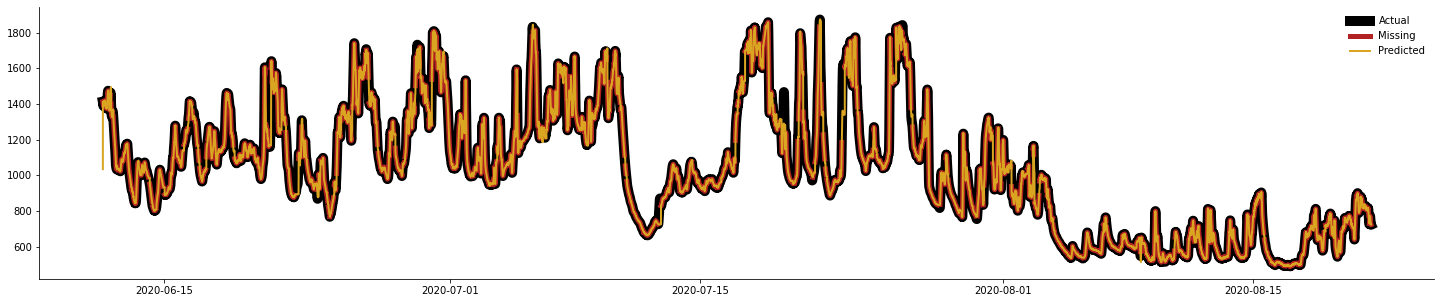

In [17]:
imp.compare_ts(imp.arima_imputed)

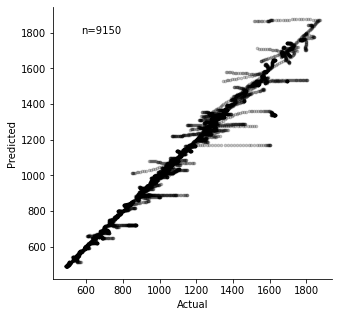

(0.9744801522506831, 24.512994184828656, 52.50481027734612, 0.9935435111039301)

In [18]:
imp.evaluate(imp.arima_imputed,plot=True)

# Evaluating

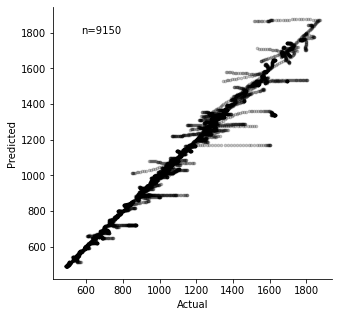

(0.9744801522506831, 24.512994184828656, 52.50481027734612, 0.9935435111039301)

In [19]:
imp.evaluate(imp.arima_imputed,plot=True)

---

# Correlation Matrix

In [98]:
def plot_correlation_matrix(df_in,save=False):
    """
    Plots the correlation matrix between the columns of the given dataframe
    """
    tick_size=18
    label_size=20
    df = df_in.copy()
    df.rename({"pm2p5_mass":"PM$_{2.5}$","pm10_mass":"PM$_{10}$","co2":"CO$_2$","temperature_c":"T","tvoc":"TVOC","co":"CO"},
              axis="columns",inplace=True)
    corr = df.corr()
    _, ax = plt.subplots(figsize=(8,8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    # plotting
    sns.heatmap(corr,vmin=-1,vmax=1,lw=2,mask=mask,square=True,
                annot_kws={'size':tick_size},fmt=".2f",annot=True,
                cmap="coolwarm_r",cbar_kws={"ticks":np.arange(-1,1.5,0.5),"pad":-0.1,"shrink":0.77,"location":"top","anchor":(0.15,1)},ax=ax)
    
    # formatting x
    ax.set_xticks(np.arange(0.5,len(df.columns)-1,1))
    ax.set_xticklabels(df.columns[:-1],fontsize=label_size)
    # formatting y
    ax.set_yticks(np.arange(1.5,len(df.columns),1))
    ax.set_yticklabels(df.columns[1:],fontsize=label_size,rotation=0)
    # colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=tick_size)
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(0.5)
    
    if save:
        plt.savefig("../reports/figures/imputation/correlation_matrix.pdf",bbox_inches="tight")
    
    plt.show()
    plt.close()

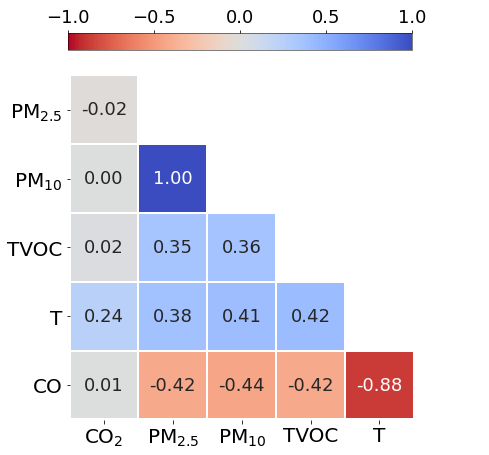

In [100]:
plot_correlation_matrix(imp.base,save=True)

# Missing at Random

PM10_MASS
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.1
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.1
	Percent: 45
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iteration: 2 - 0.5
	Percent: 10
		Iteration: 0 - 0.4
		Iteration: 1 - 0.5
		Iteration: 2 - 0.4
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4

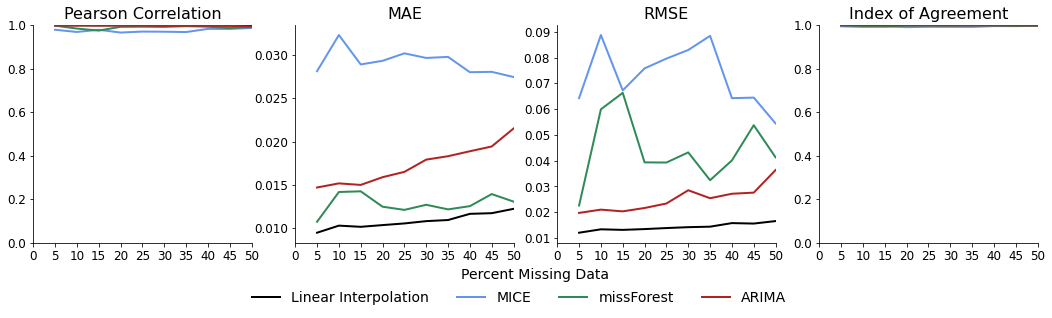

CO2
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.1
		Iteration: 2 - 0.0
	Percent: 45
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.3
		Iteration: 1 - 0.4
		Iteration: 2 - 0.4
	Percent: 10
		Iteration: 0 - 0.2
		Iteration: 1 - 0.4
		Iteration: 2 - 0.2
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Ite

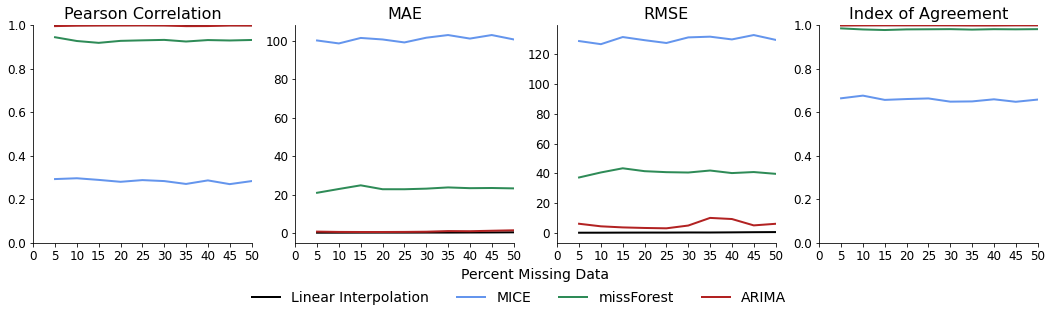

PM2P5_MASS
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 45
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.0
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iteration: 2 - 0.4
	Percent: 10
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iteration: 2 - 0.4
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 - 0.

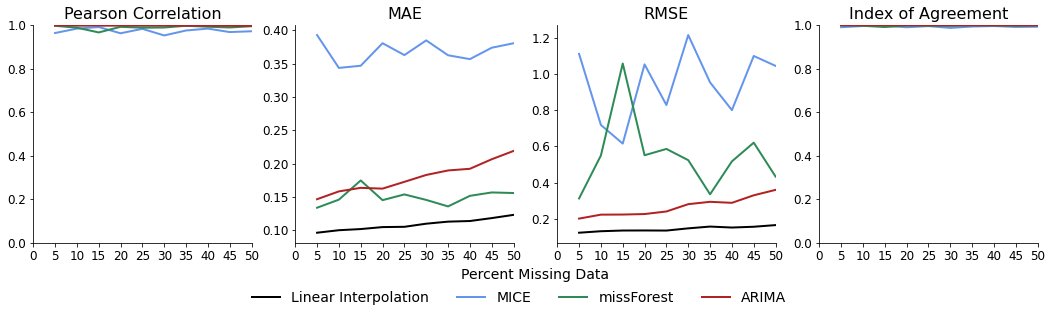

TVOC
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.1
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 45
		Iteration: 0 - 0.1
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.4
		Iteration: 1 - 0.1
		Iteration: 2 - 0.4
	Percent: 10
		Iteration: 0 - 0.4
		Iteration: 1 - 0.1
		Iteration: 2 - 0.4
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		It

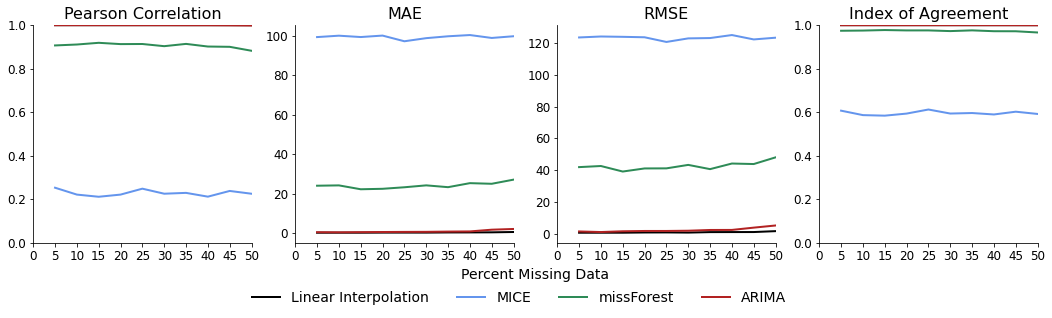

TEMPERATURE_C
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.1
	Percent: 45
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iteration: 2 - 0.2
	Percent: 10
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iteration: 2 - 0.3
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 -

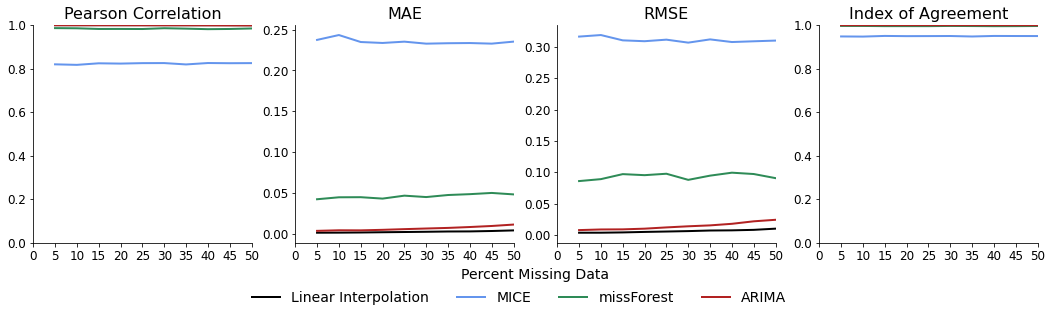

CO
Linear Interpolation
	Percent: 5
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 10
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 15
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 20
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 25
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 30
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 35
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 40
		Iteration: 0 - 0.0
		Iteration: 1 - 0.0
		Iteration: 2 - 0.0
	Percent: 45
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.0
	Percent: 50
		Iteration: 0 - 0.1
		Iteration: 1 - 0.1
		Iteration: 2 - 0.1
MICE
	Percent: 5
		Iteration: 0 - 0.4
		Iteration: 1 - 0.2
		Iteration: 2 - 0.4
	Percent: 10
		Iteration: 0 - 0.3
		Iteration: 1 - 0.4
		Iteration: 2 - 0.4
	Percent: 15
		Iteration: 0 - 0.4
		Iteration: 1 - 0.4
		Iter

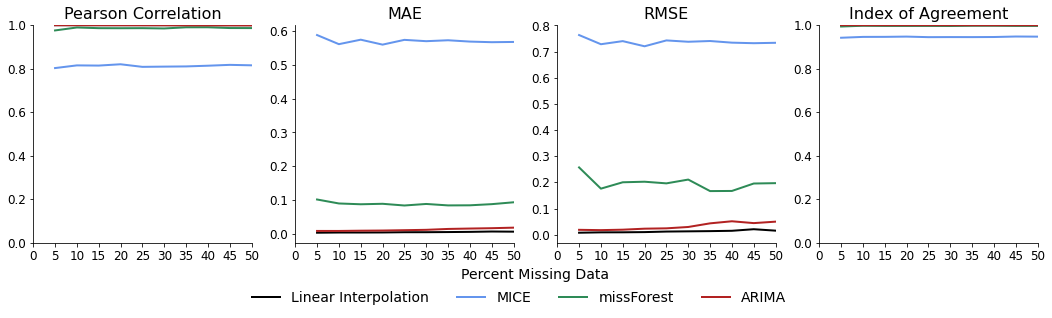

In [152]:
mar = False
if mar:
    for param in ["pm10_mass","co2","pm2p5_mass","tvoc","temperature_c","co"]:
        print(param.upper())
        res = imp.run_at_random(param=param,verbose=True,start_time=datetime(2020,6,15),end_time=datetime(2020,6,22))
        imp.save_res(res)
        imp.compare_methods(res,save=True,annot=f"{param}_week")

<div class="alert-block alert alert-success">
    
The ARIMA model is incredible
    
</div>

# Finding Max Missing Period
Determining what is the maximum length of data that we can remove and still get viable results.

In [ ]:
for param, order in zip(["pm2p5_mass"],[(2,0,2)]):#zip(["co2","pm2p5_mass","co","tvoc","temperature_c"],[(1,1,0),(2,0,2),(1,2,1),(2,0,1),(2,0,2)]):
    imp.set_arima_order(order)
    #[5,10,15,30,60,90,120,180,240,300,360,420,480,540,600,660,720]
    res = imp.find_max_period(start_time=datetime(2020,6,15),end_time=datetime(2020,7,15),param=param,methods=["missForest"],
                              periods=[660,720],
                              verbose=True,save=True)
    imp.compare_methods(res,xlim=[0,600],xlabel="Periods of Missing Data (minutes)",save=False,annot=f"{param}_max_periods")

missForest
	660
		Iteration: 0 - 1597.5
		Iteration: 1 - 1583.5
		Iteration: 2 - 1598.6
	720
		Iteration: 0 - 1687.7
		Iteration: 1

## Missing Periods

Method: MICE - Period: 60 - Percent: 5


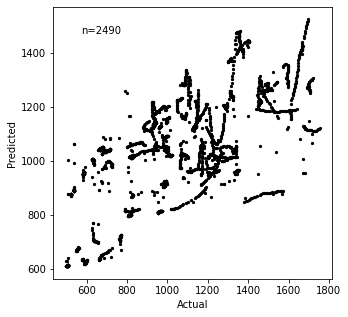

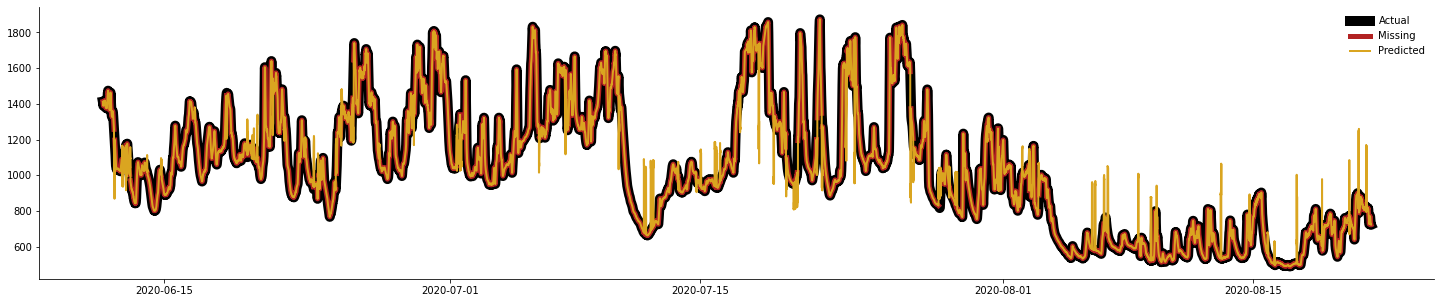

Method: MICE - Period: 60 - Percent: 10


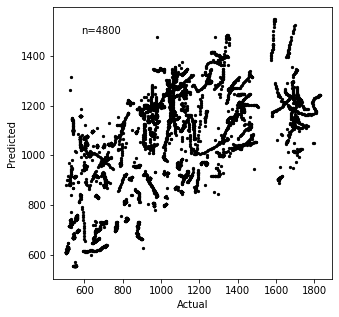

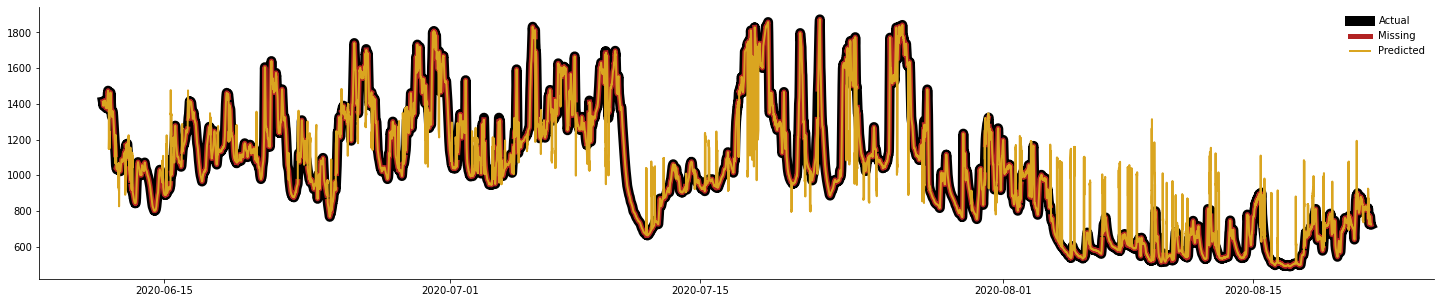

Method: MICE - Period: 60 - Percent: 15


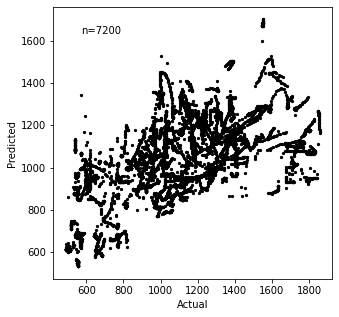

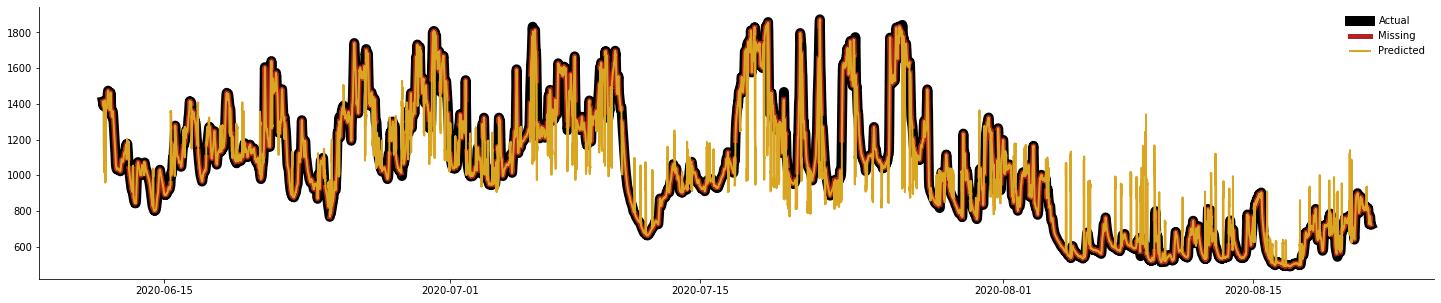

Method: MICE - Period: 60 - Percent: 20


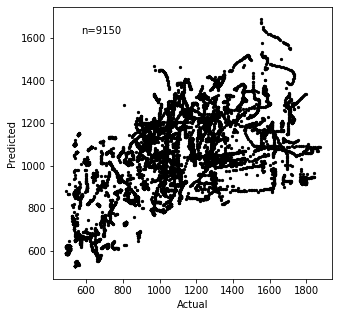

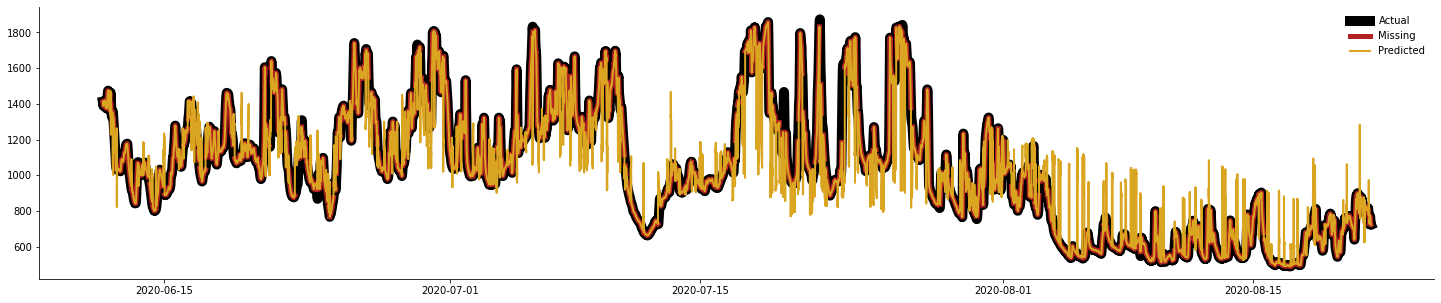

Method: MICE - Period: 60 - Percent: 30


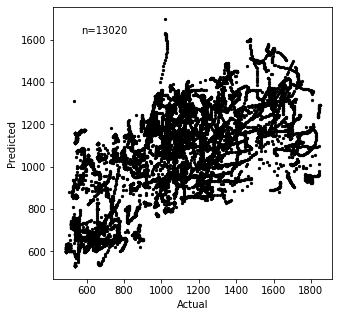

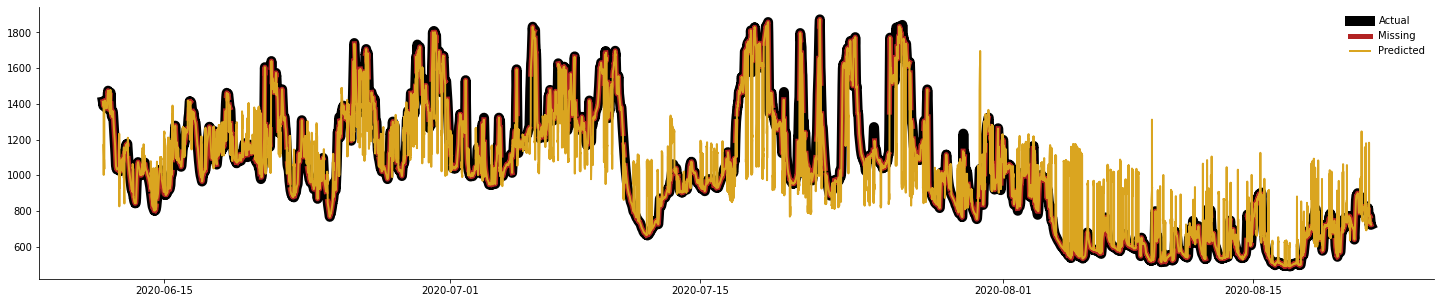

Method: MICE - Period: 60 - Percent: 35


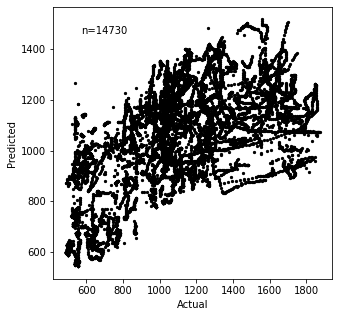

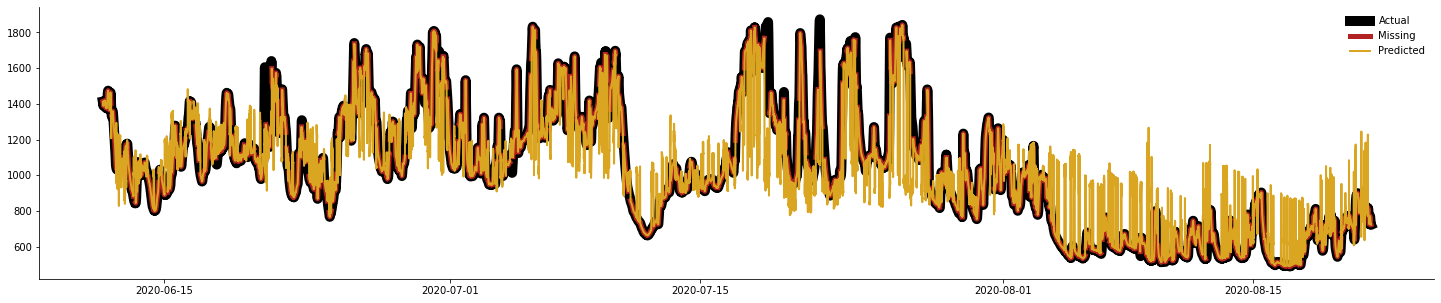

Method: MICE - Period: 60 - Percent: 40


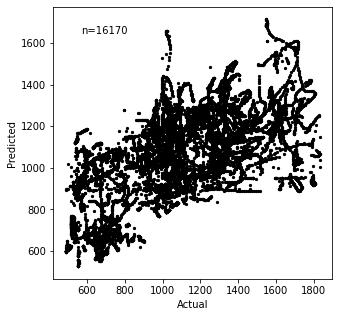

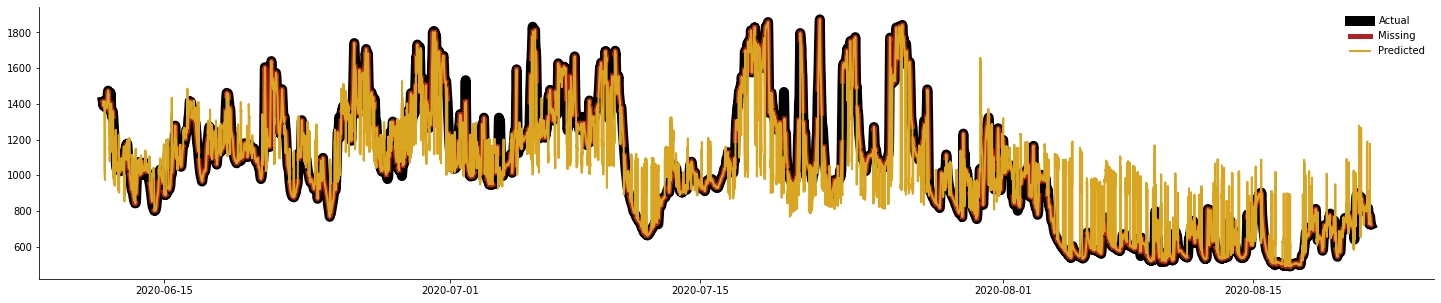

Method: MICE - Period: 60 - Percent: 45


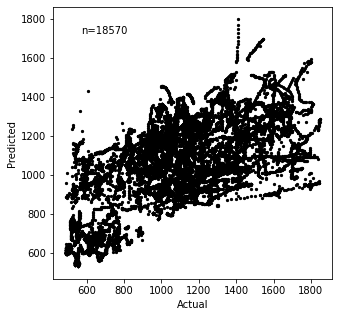

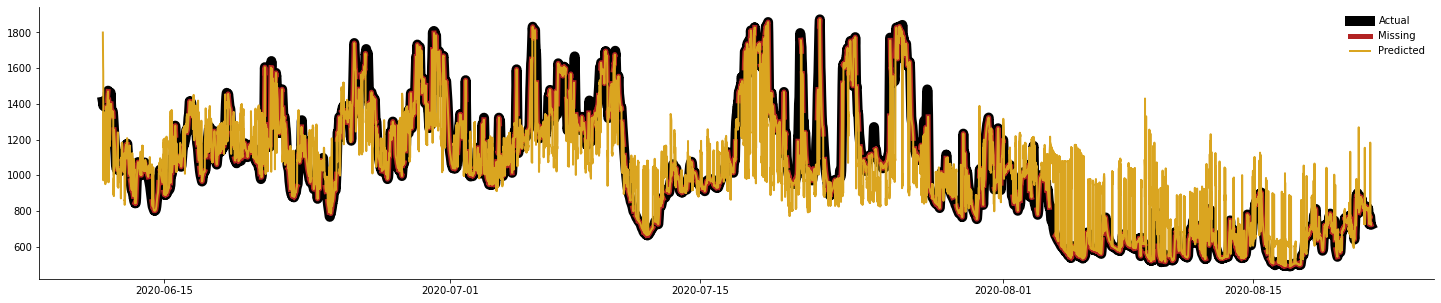

Method: MICE - Period: 60 - Percent: 50


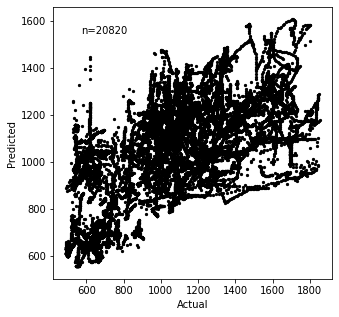

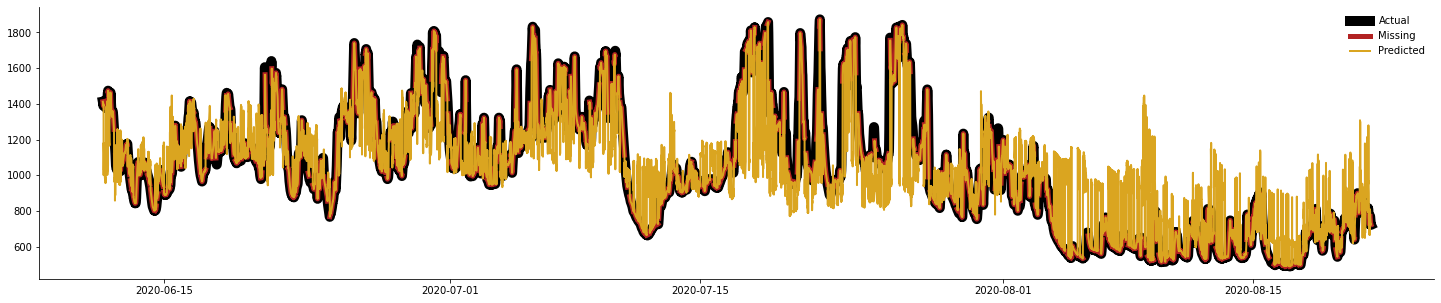

Method: missForest - Period: 60 - Percent: 5


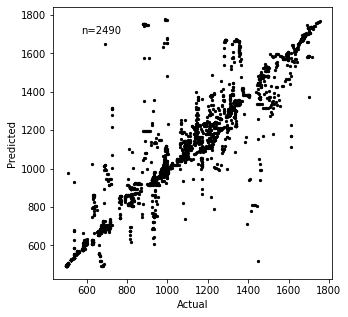

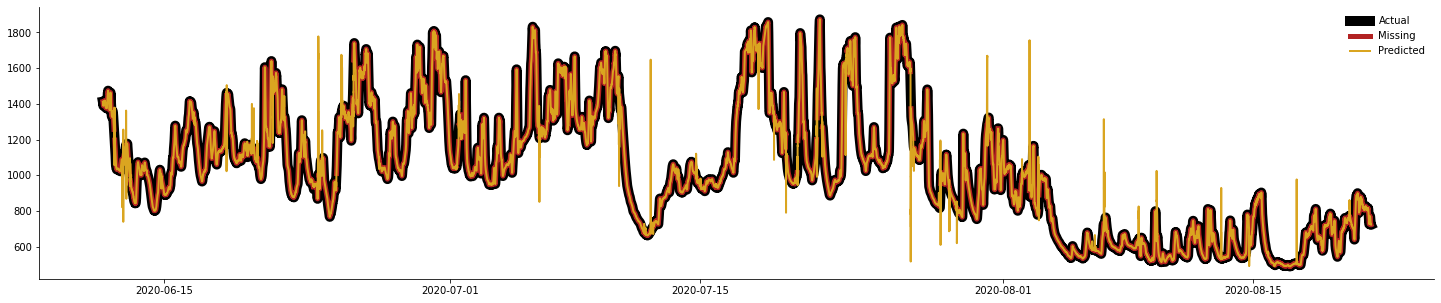

Method: missForest - Period: 60 - Percent: 10


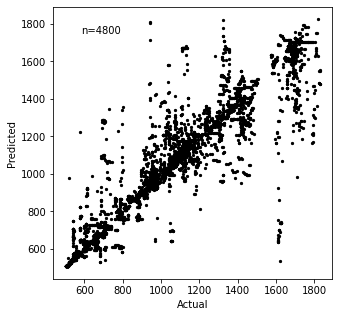

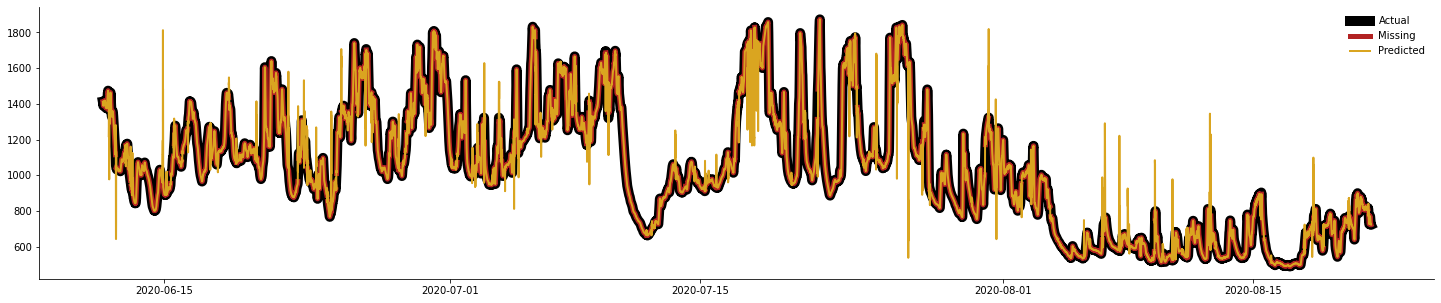

Method: missForest - Period: 60 - Percent: 15


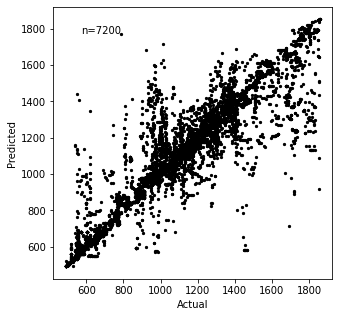

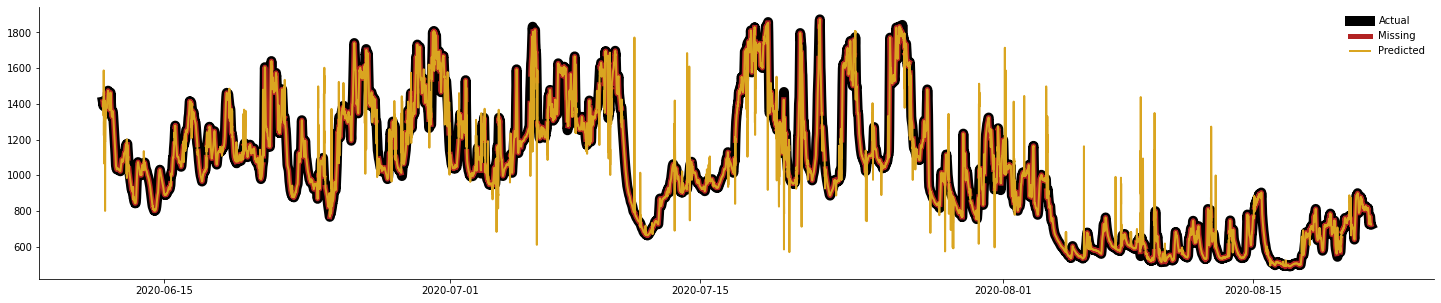

Method: missForest - Period: 60 - Percent: 20


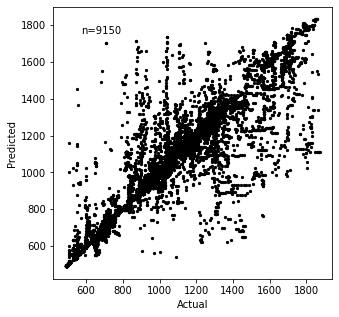

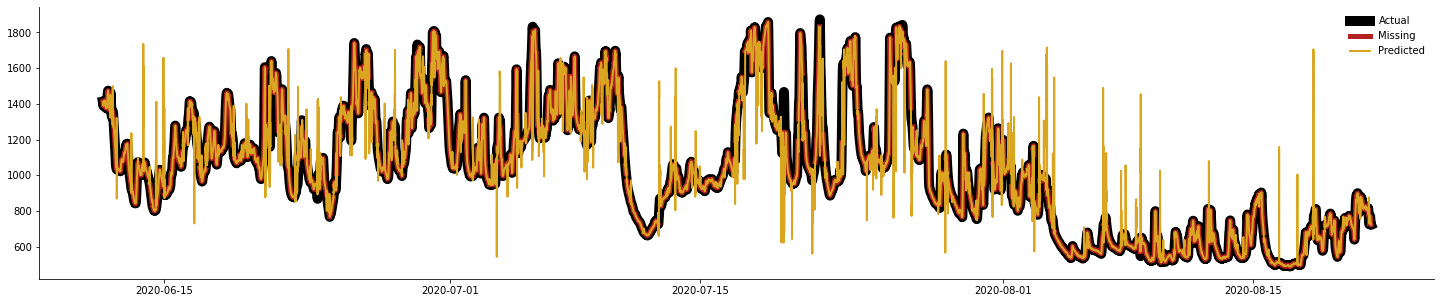

Method: missForest - Period: 60 - Percent: 30


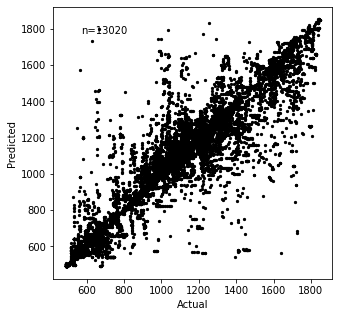

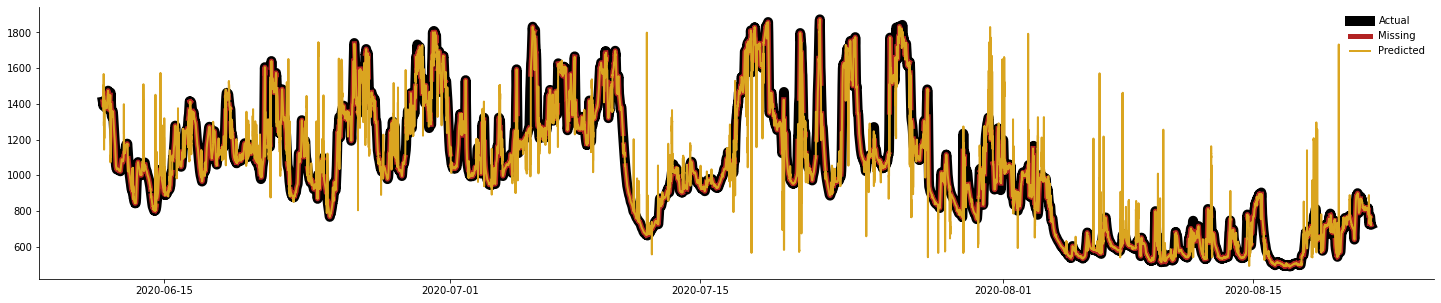

Method: missForest - Period: 60 - Percent: 35


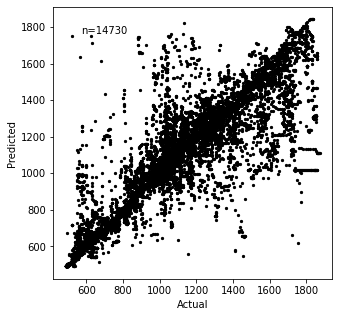

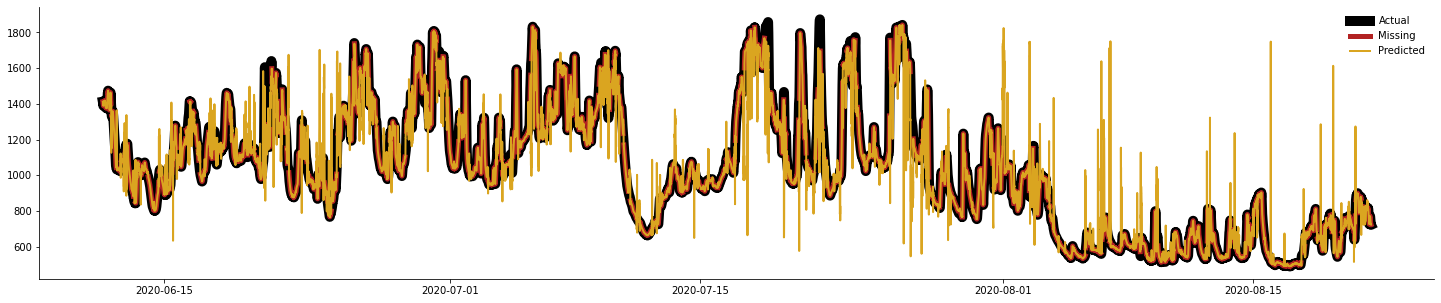

Method: missForest - Period: 60 - Percent: 40


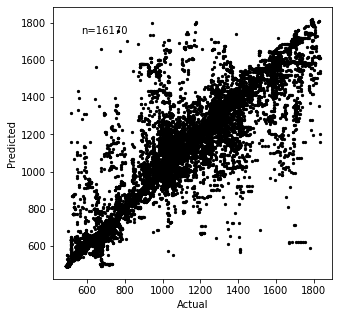

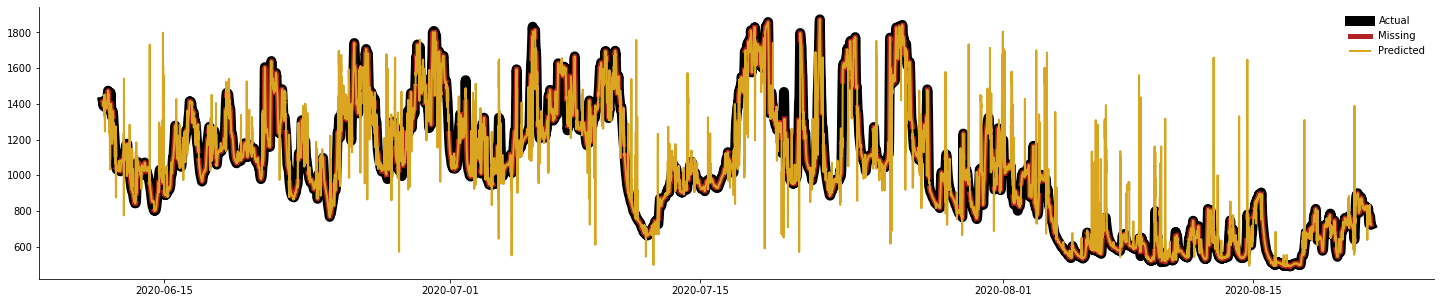

Method: missForest - Period: 60 - Percent: 45


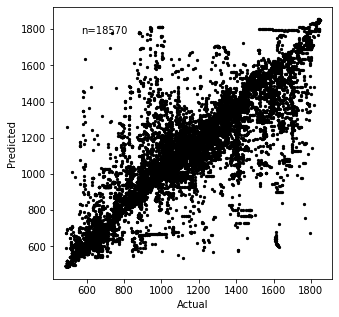

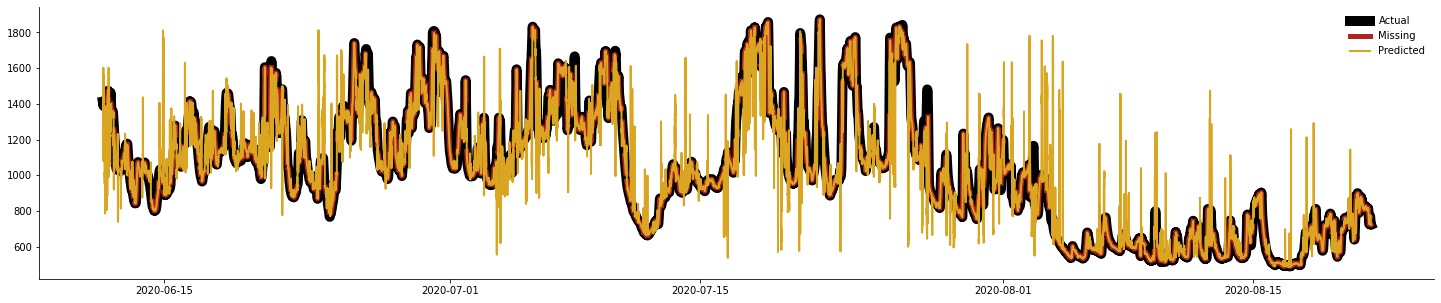

Method: missForest - Period: 60 - Percent: 50


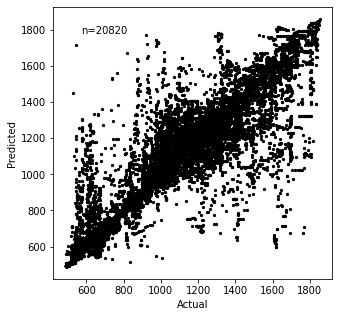

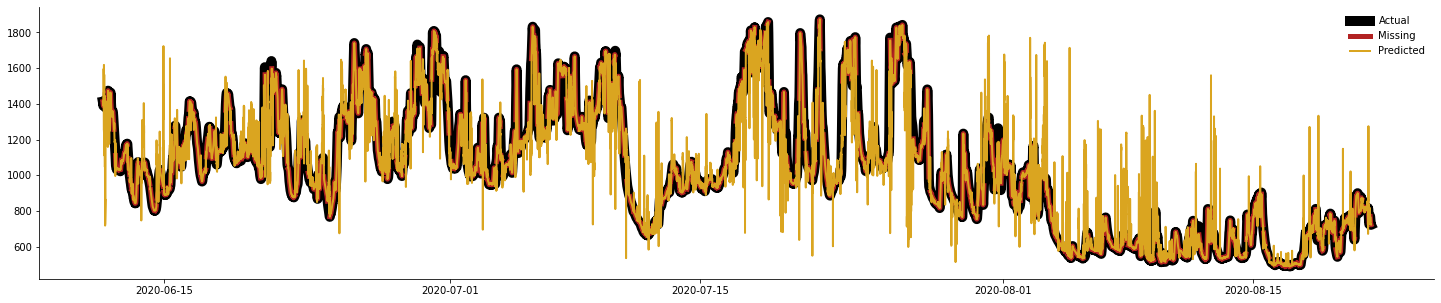

Method: ARIMA - Period: 60 - Percent: 5


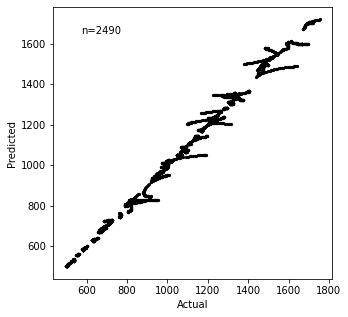

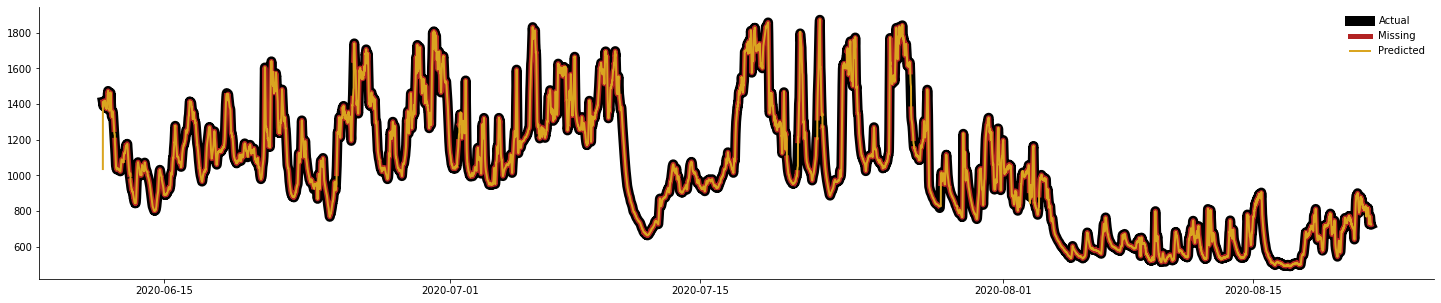

Method: ARIMA - Period: 60 - Percent: 10


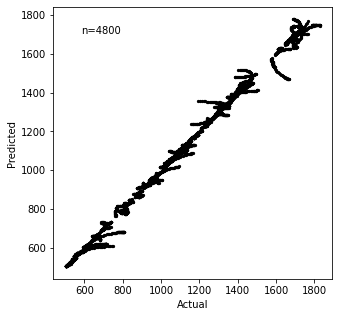

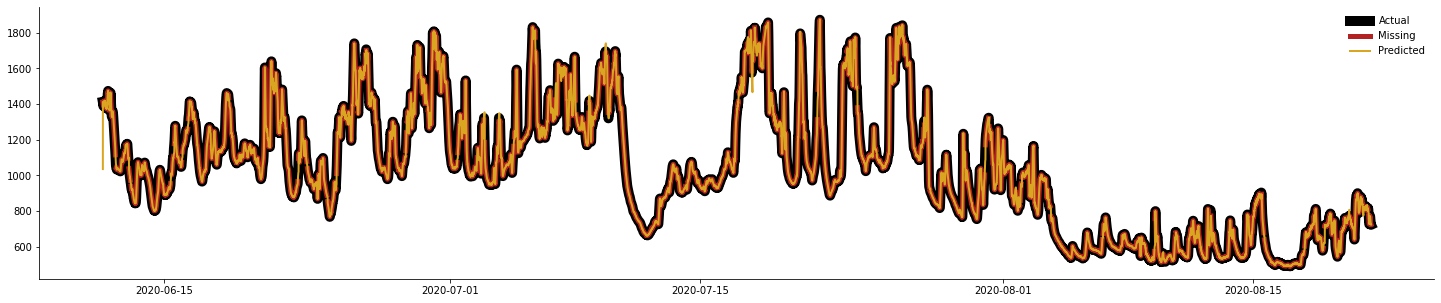

Method: ARIMA - Period: 60 - Percent: 15


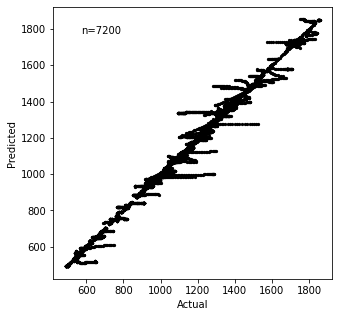

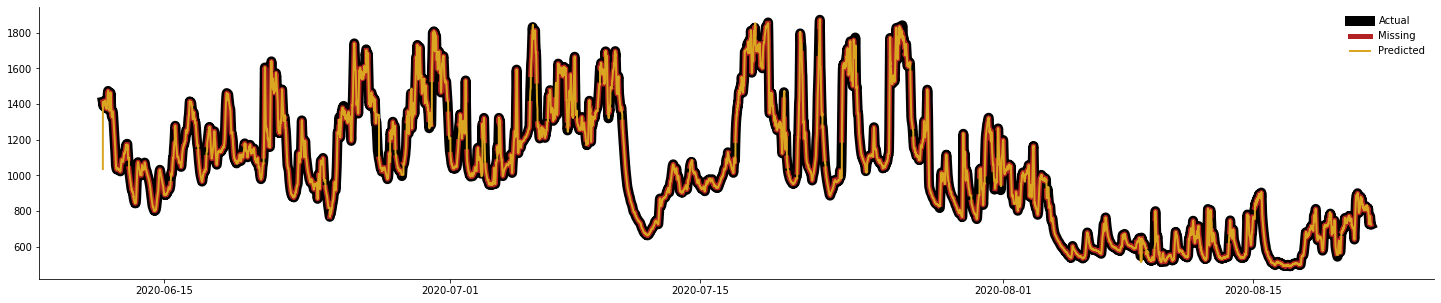

Method: ARIMA - Period: 60 - Percent: 20


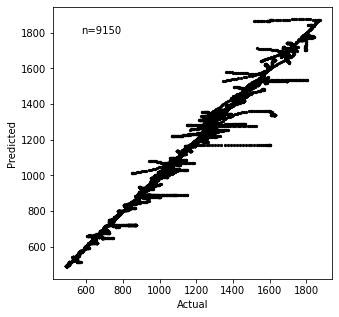

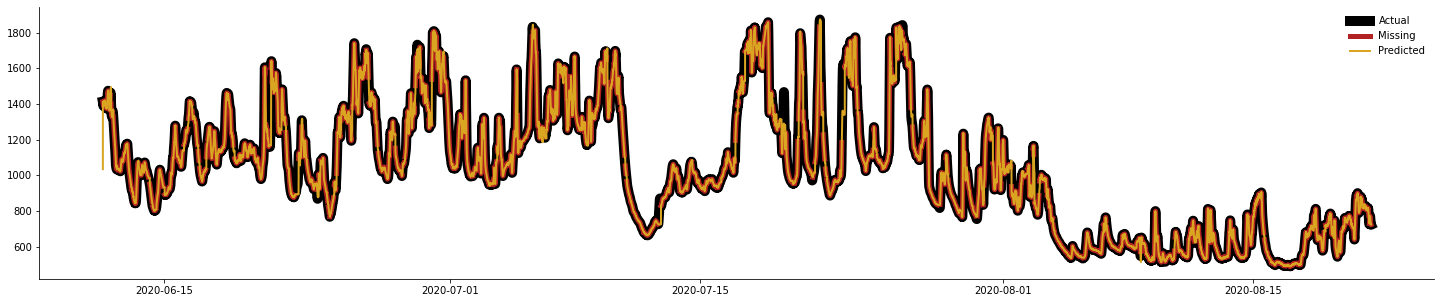

Method: ARIMA - Period: 60 - Percent: 30


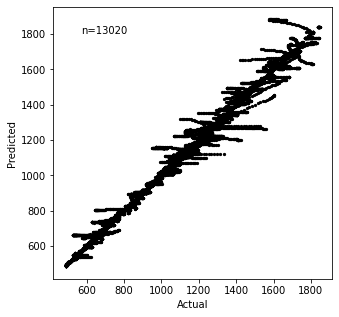

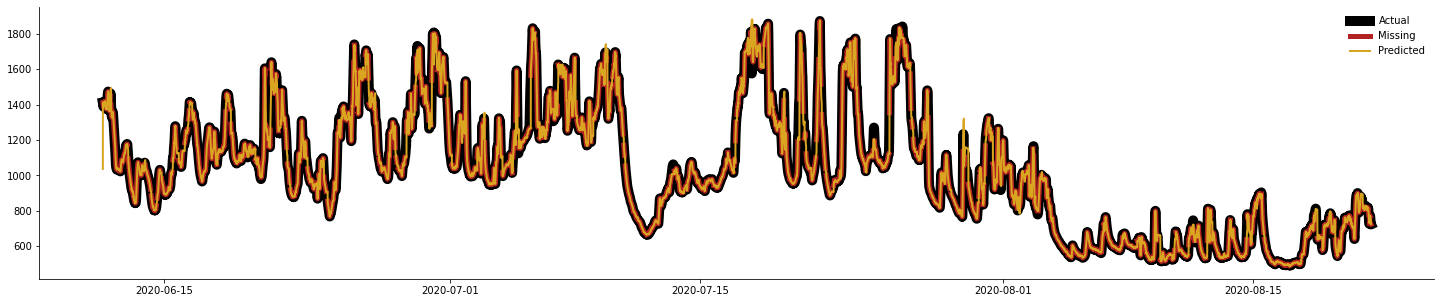

Method: ARIMA - Period: 60 - Percent: 35


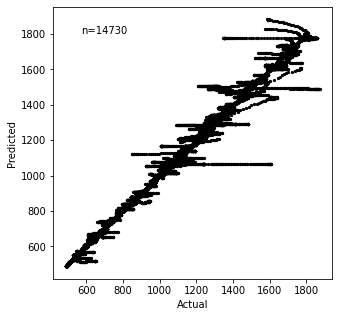

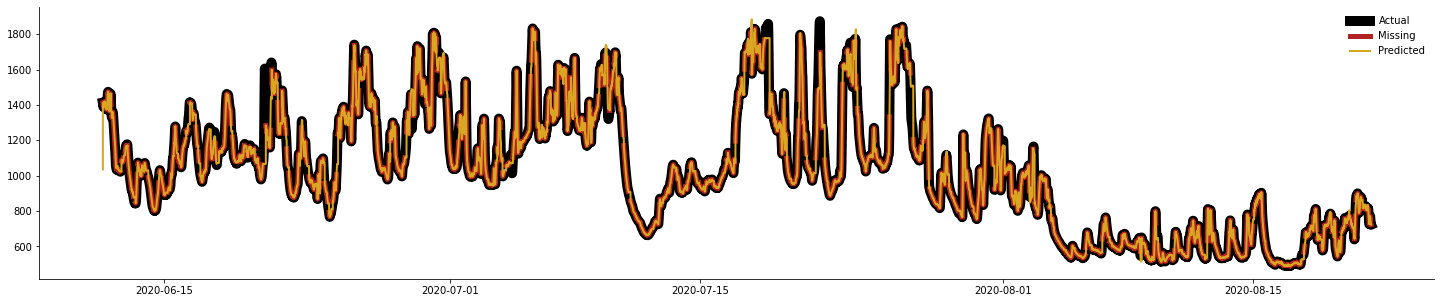

Method: ARIMA - Period: 60 - Percent: 40


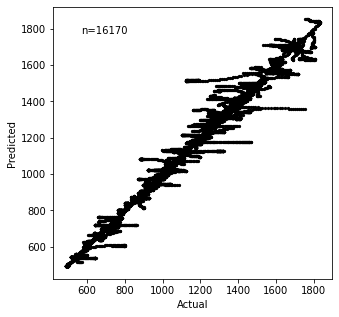

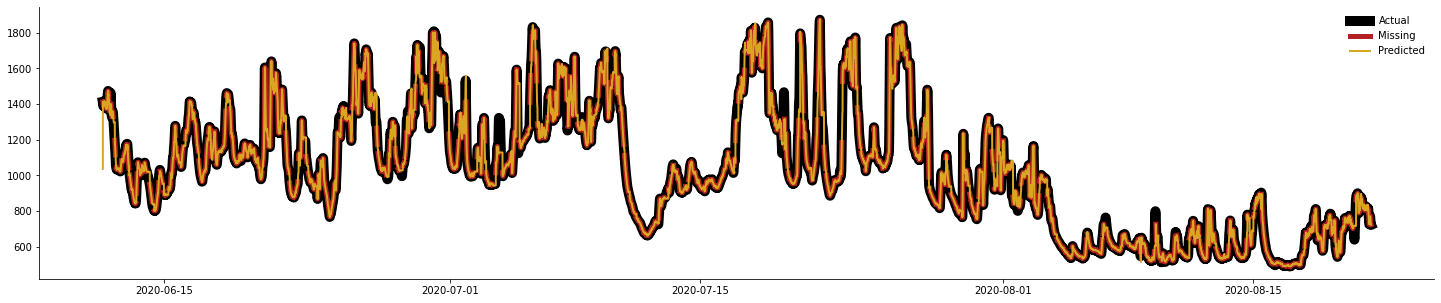

Method: ARIMA - Period: 60 - Percent: 45


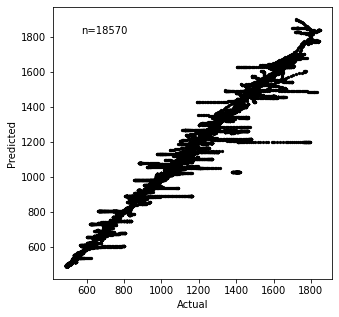

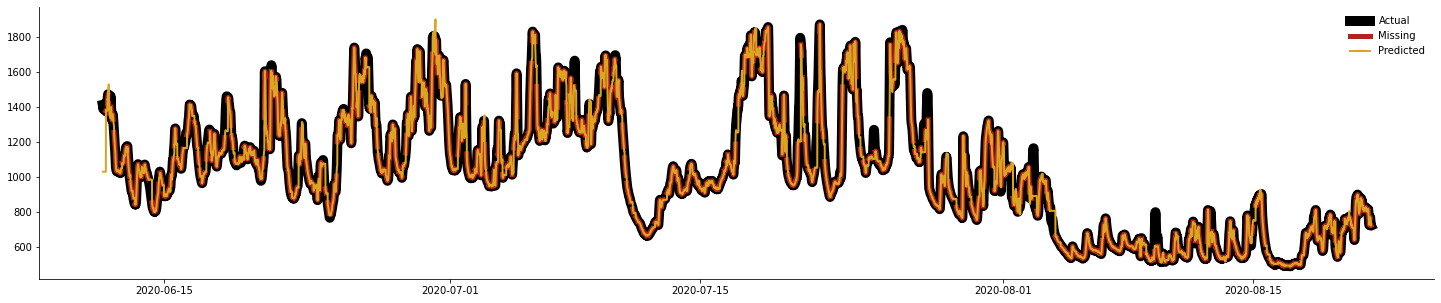

Method: ARIMA - Period: 60 - Percent: 50


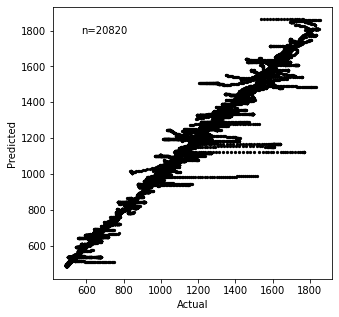

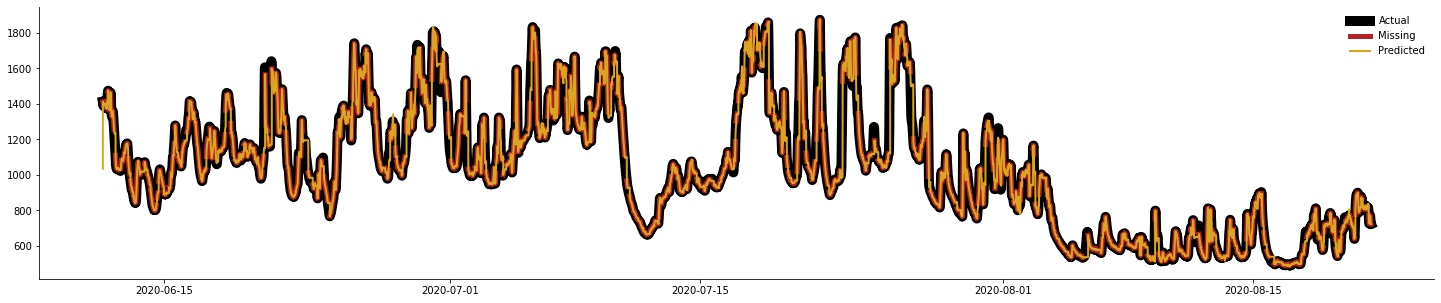

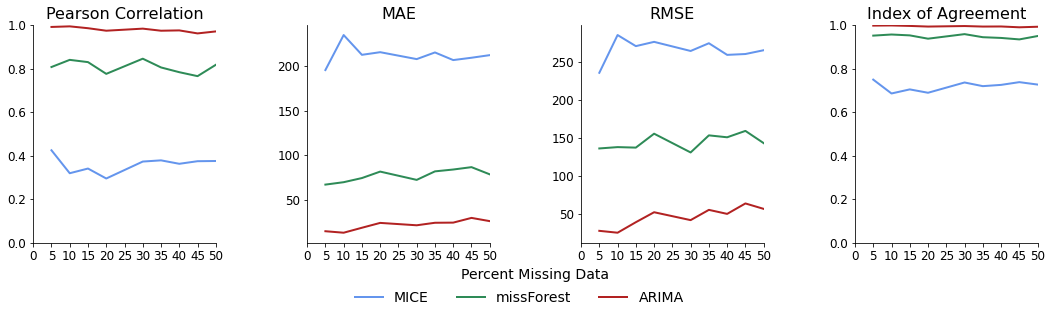

Method: MICE - Period: 120 - Percent: 5


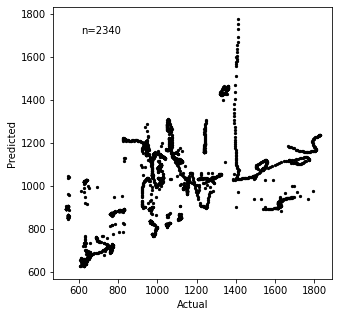

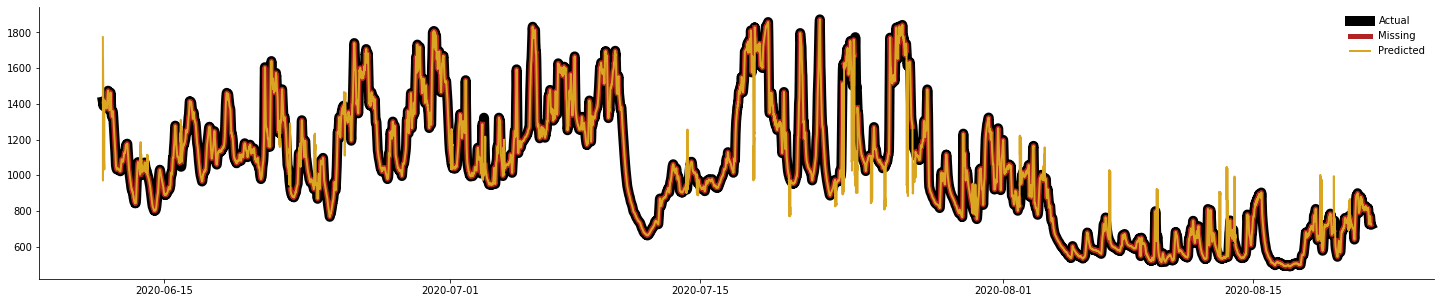

Method: MICE - Period: 120 - Percent: 10


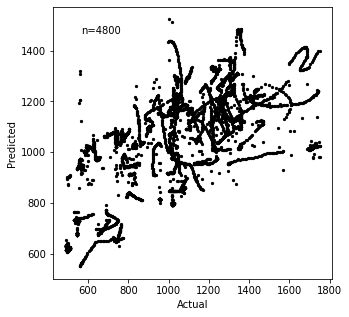

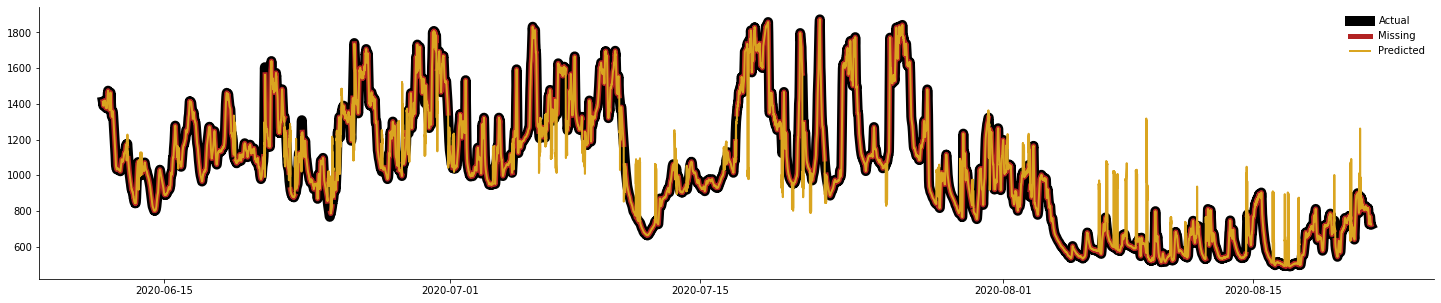

Method: MICE - Period: 120 - Percent: 15


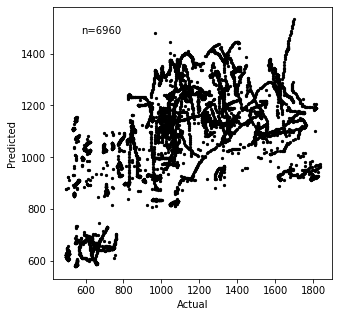

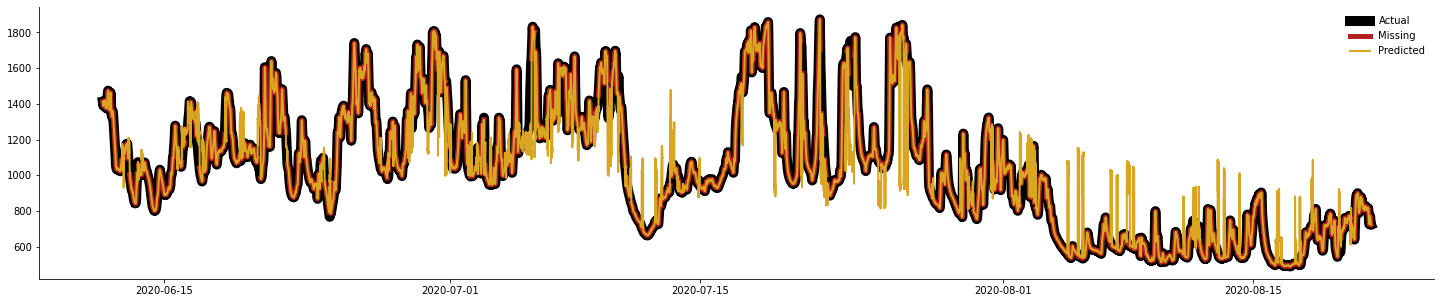

Method: MICE - Period: 120 - Percent: 20


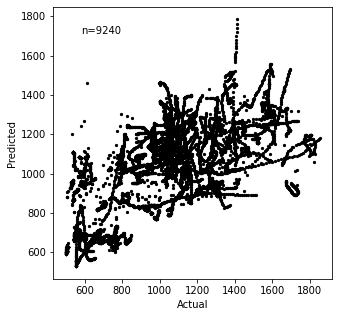

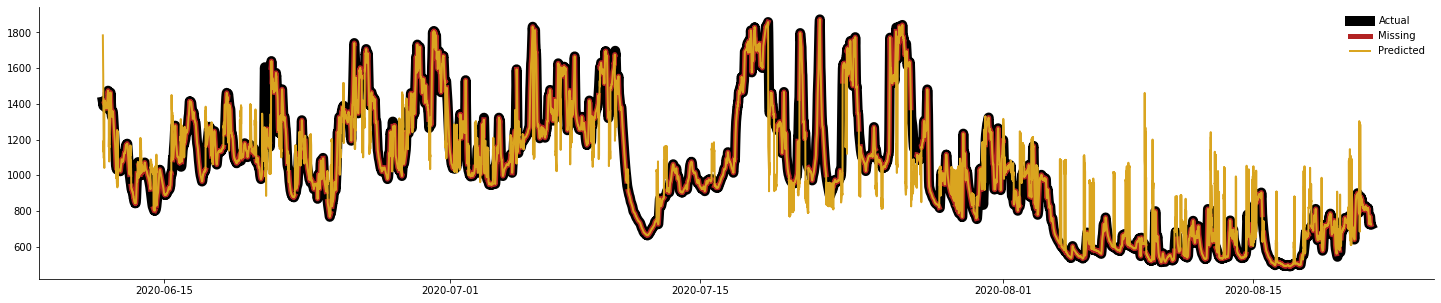

Method: MICE - Period: 120 - Percent: 30


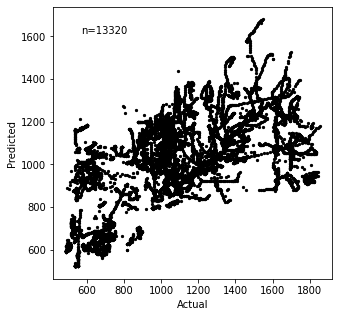

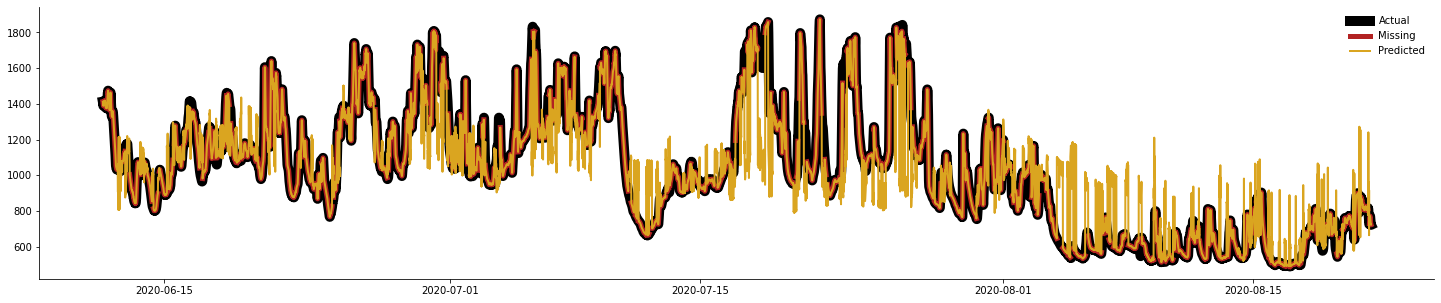

Method: MICE - Period: 120 - Percent: 35


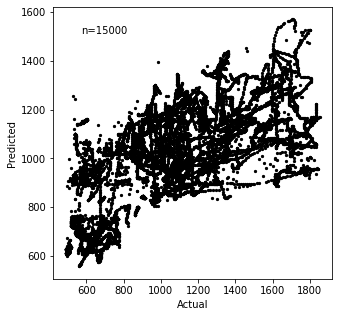

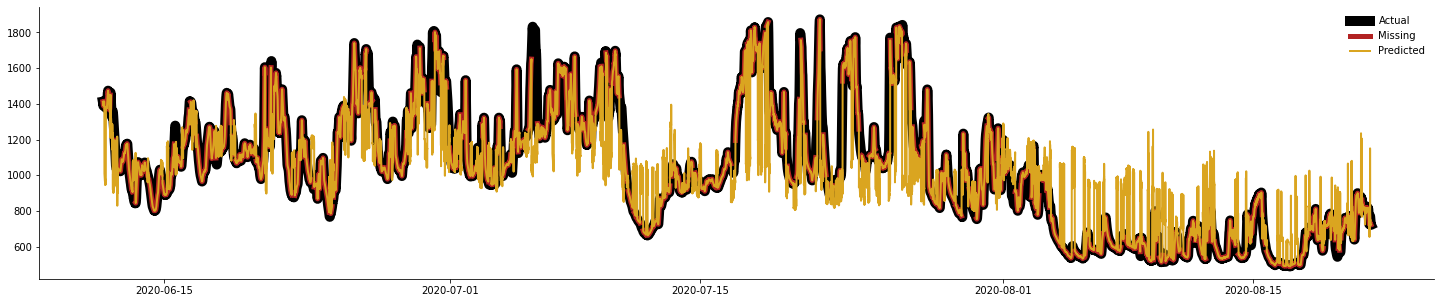

Method: MICE - Period: 120 - Percent: 40


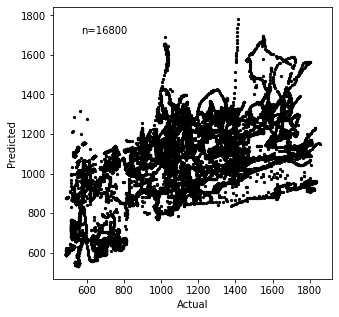

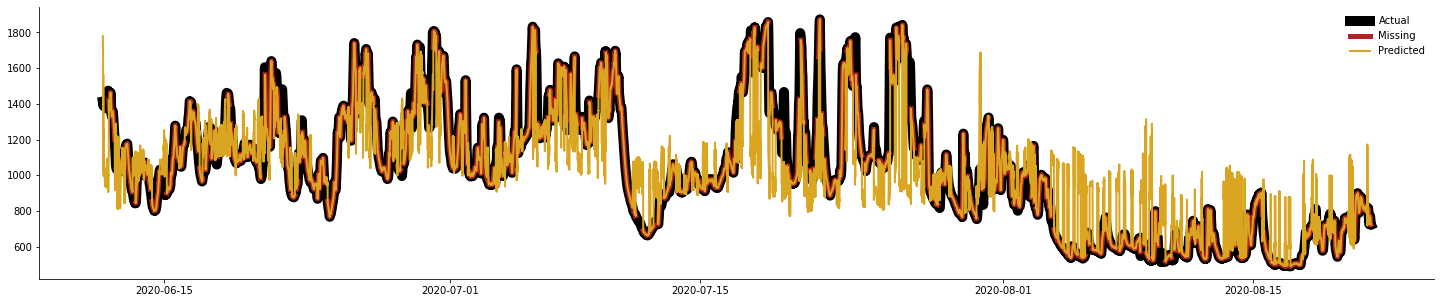

Method: MICE - Period: 120 - Percent: 45


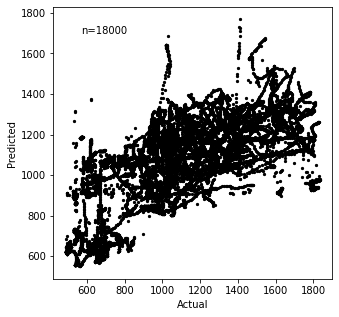

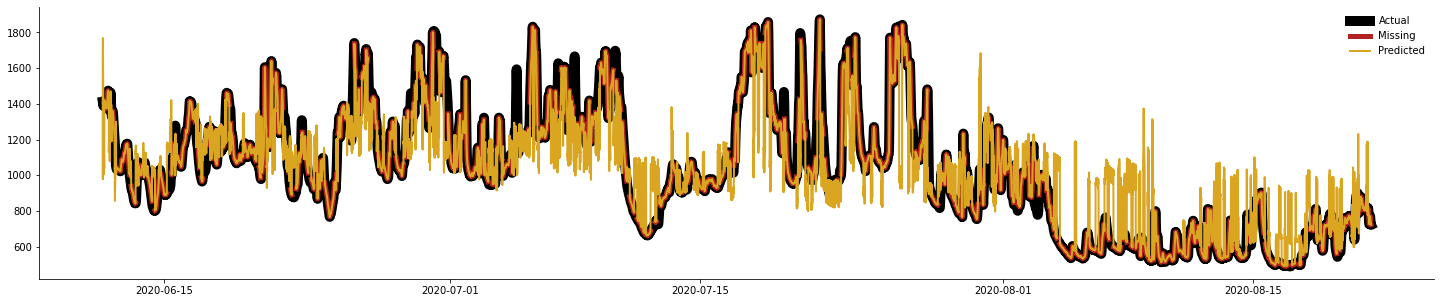

Method: MICE - Period: 120 - Percent: 50


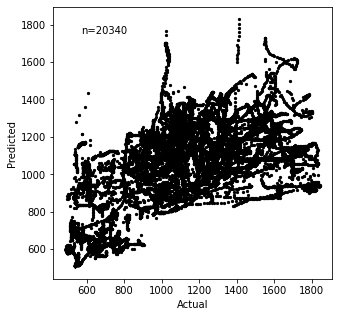

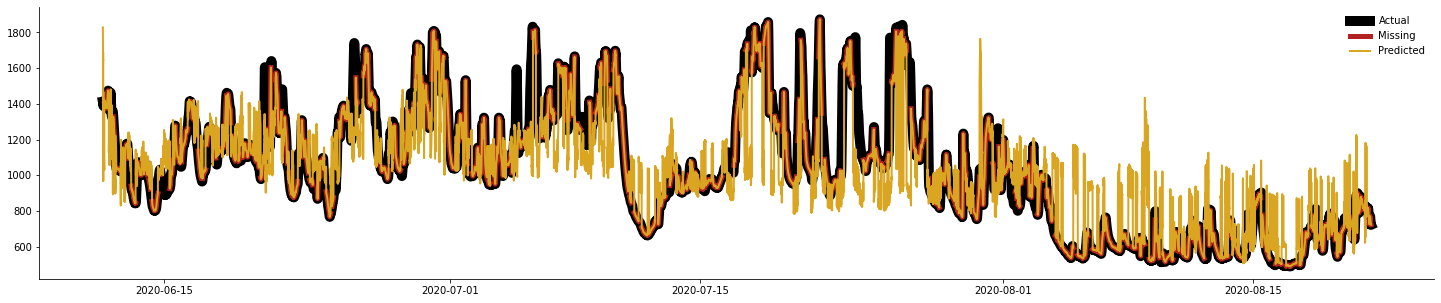

Method: missForest - Period: 120 - Percent: 5


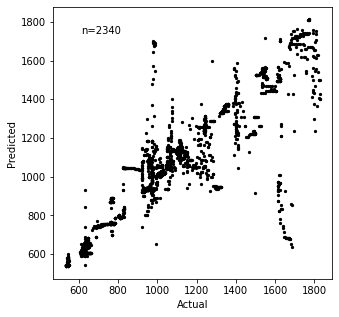

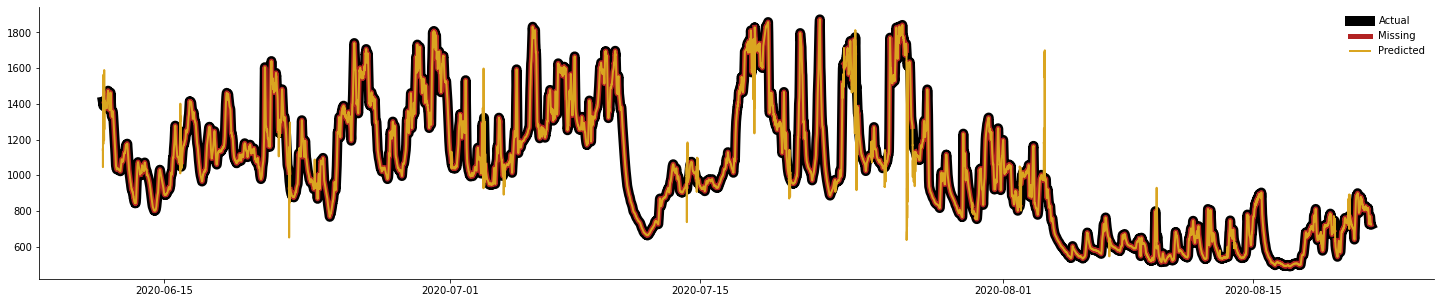

Method: missForest - Period: 120 - Percent: 10


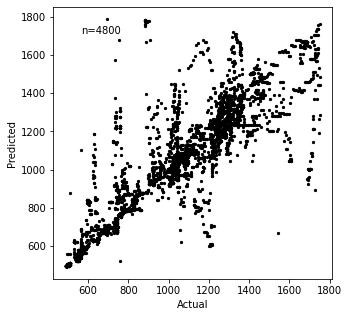

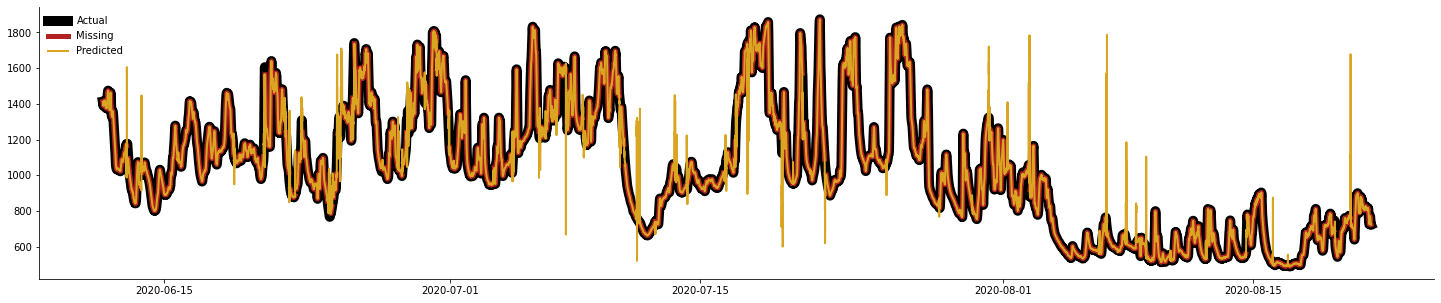

Method: missForest - Period: 120 - Percent: 15


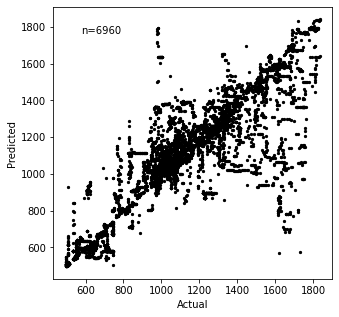

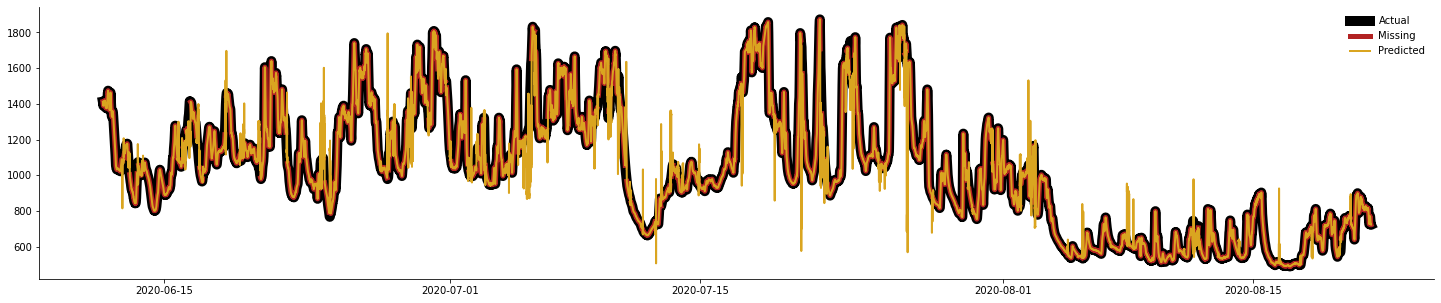

KeyboardInterrupt: 

In [118]:
for param in ["co2","pm2p5_mass","co","temperature_c"]:
    for period in [60,120]:
        res = imp.run_periods_at_random(period=period,verbose=True)
        imp.compare_methods(res,save=False,annot=f"{param}_{period}")